# Rat weight gain data in lmer, lmm, Stan and Mamba

The `rats` data are described in the `RatWeightData` notebook where they are converted from a matrix to a saved R data frame.  We could do the initial data manipulation in [R](http://R-project.org) through the [RCall](https://github.com/JuliaStats/RCall.jl) package for [Julia](https://julialang.org) but we chose to use packages from the "Hadleyverse" that cannot easily be installed on (https://juliabox.org)

In [1]:
using DataFrames, MixedModels, Mamba, RCall, Stan

Environment variable JULIA_SVG_BROWSER not found.


In [2]:
versioninfo(true)

Julia Version 0.4.3
Commit a2f713d (2016-01-12 21:37 UTC)
Platform Info:
  System: Linux (x86_64-unknown-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz
  WORD_SIZE: 64
           Ubuntu 14.04.3 LTS
  uname: Linux 3.13.0-57-generic #95-Ubuntu SMP Fri Jun 19 09:28:15 UTC 2015 x86_64 x86_64
Memory: 120.07188034057617 GB (108985.25 MB free)
Uptime: 35740.0 sec
Load Avg:  0.203125  0.19384765625  0.2001953125
Intel(R) Xeon(R) CPU E5-2670 v2 @ 2.50GHz: 
          speed         user         nice          sys         idle          irq
#1-16  2500 MHz     508466 s       1205 s     147357 s   56364318 s          7 s

  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3
Environment:
  CMDSTAN_HOME = /usr/share/cmdstan
  HOME = /home/juser
  PATH = /usr/local/texlive/2014/bin/x86_64-linux:/usr/local/bin:/usr/bin:/bin:/sbin:/usr/sbin:/opt/julia/bin
  R_HOME = /usr/lib/R

Package Directory: /home/juser/.j

We retrieve the data as an `R` object, and copy it under the same name into Julia.

In [4]:
R"""
rats <- readRDS("./rats.rds")
""";
@rget rats

,id,day,y
1,1,8,151
2,2,8,145
3,3,8,147
4,4,8,155
5,5,8,135
6,6,8,159
7,7,8,141
8,8,8,159
9,9,8,177
10,10,8,134


## Plot the data

At this point we do something radical and plot the data.  I have never seen a data plot in any of the MCMC exampes that use these data.  The panels are ordered (bottom to top, left to right) according to increasing average weight of the rat.  The aspect ratio is chosen so that a typical slope of the within-rat least squares line is approximately 45 degrees on the plotting surface.

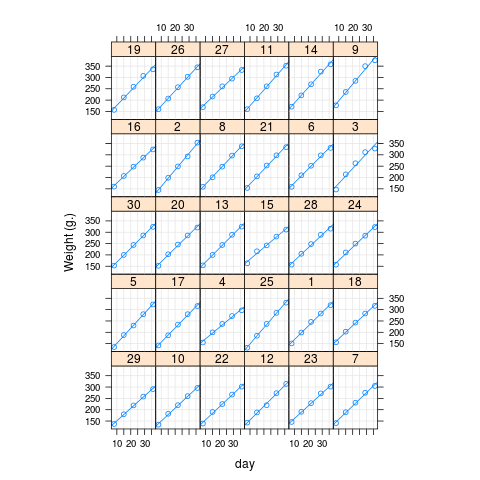

In [5]:
R"""
library(lattice)
print(xyplot(y ~ day | reorder(id, y), rats, type = c('p','g','r'),
  aspect = 'xy', ylab = "Weight (g.)"))
""";

There is an overall linear trend in the weight with respect to time but there is also noticeable downward curvature for many of the rats.  Nevertheless we will start with a model with linear model with vector-valued random effects for slope and intercept by rat.

## Fitting the vector-valued random effects in lme4

The simplest way to write the model is `weight ~ 1 + day + (1 + day|id)` which allows for correlated random effects for slope and intercept for each rat.

In [6]:
R"""
suppressPackageStartupMessages(library(lme4))
m1 <- lmer(y ~ 1 + day + (1 + day | id), rats, REML = FALSE)
summary(m1)
"""

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y ~ 1 + day + (1 + day | id)
   Data: rats

     AIC      BIC   logLik deviance df.resid 
  1108.1   1126.1   -548.0   1096.1      144 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6317 -0.5422  0.1154  0.4948  2.6188 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 110.1392 10.4947       
          day           0.2495  0.4995  -0.15
 Residual              36.1756  6.0146       
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 106.5676     2.2591   47.17
day           6.1857     0.1038   59.58

Correlation of Fixed Effects:
    (Intr)
day -0.343


Because `day` is days past birth, the estimate of a typical birth weight is 106.6 g. and the typical weight gain per day after birth is 6.2 g./day.  As is common in linear regression models where `x = 0` is to the left of the observed data, there is a negative correlation, -0.343, between these estimates.  The standard deviation of the random effects for the intercept (i.e. the birth weight) is 10.5 g. and the standard deviation of the random effects for the slope is 0.50 g./day.  There is a slight negative within-rat correlation, -0.15, of these random effects.  We can check the conditional means of these random effects

In [7]:
rcall(:ranef, :m1)

RCall.RObject{RCall.VecSxp}
$id
    (Intercept)         day
1   -0.05553214 -0.12578651
2  -11.28871381  0.78307023
3    2.56173870  0.33371487
4    6.95772594 -0.80488489
5  -15.66765773  0.23713605
6    5.86444226  0.04898243
7   -7.44611157 -0.29292676
8    0.49139122  0.24410473
9   17.10933172  1.07538535
10 -12.66716696 -0.48326773
11   1.53330811  0.65324070
12 -10.44571308 -0.17582192
13   0.19475081 -0.02076168
14  11.51006572  0.64210468
15  13.77174164 -0.65506265
16   6.80249948 -0.20317462
17  -9.93634401 -0.01121433
18   4.30992548 -0.30851412
19   5.00795524  0.27921279
20   1.52862500 -0.12086316
21   0.84085073  0.23631872
22  -8.07783593 -0.42464430
23  -3.50288046 -0.49138374
24   7.23352917 -0.23288734
25 -19.40139098  0.55158120
26   2.62570253  0.40267231
27  14.44659266 -0.14725654
28   6.31630913 -0.28786142
29 -10.62557058 -0.64438331
30   0.00843169 -0.05682907



or, a better choice, plot these conditional modes.

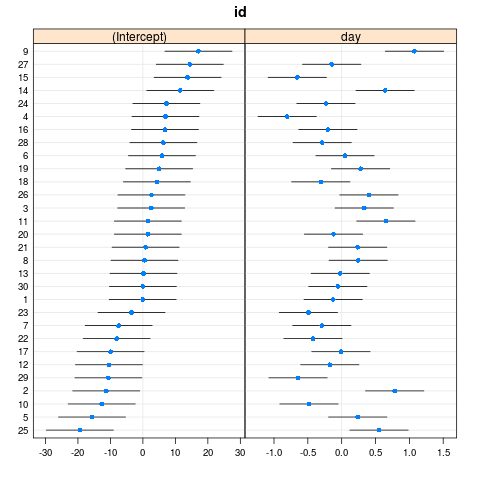

In [8]:
R"""
re1 <- ranef(m1, condVar = TRUE)
print(dotplot(re1, scales = list(x = list(relation = 'free'))))[[1]]
""";

We can check for non-negligible correlation of the random effects by fitting a model with uncorrelated random effects and comparing the fits.

In [9]:
R"""
m2 <- lmer(y ~ 1 + day + (1|id) + (0 + day|id), rats, REML = FALSE)
options(show.signif.stars = FALSE)
anova(m2, m1)
"""

RCall.RObject{RCall.VecSxp}
$id

Data: rats
Models:
m2: y ~ 1 + day + (1 | id) + (0 + day | id)
m1: y ~ 1 + day + (1 + day | id)
   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
m2  5 1106.4 1121.5 -548.21   1096.4                         
m1  6 1108.1 1126.1 -548.03   1096.1 0.3645      1      0.546


In [10]:
rcall(:summary, :m2)

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y ~ 1 + day + (1 | id) + (0 + day | id)
   Data: rats

     AIC      BIC   logLik deviance df.resid 
  1106.4   1121.5   -548.2   1096.4      145 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5962 -0.5331  0.1162  0.5036  2.5868 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 101.6460 10.0820 
 id.1     day           0.2319  0.4815 
 Residual              36.8273  6.0686 
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 106.5676     2.2014   48.41
day           6.1857     0.1012   61.14

Correlation of Fixed Effects:
    (Intr)
day -0.247


## Fitting the same models with lmm in Julia

In [11]:
m1 = fit!(lmm(y ~ 1 + day + (1 + day | id), rats))

Linear mixed model fit by maximum likelihood
 logLik: -548.028661, deviance: 1096.057323, AIC: 1108.057323, BIC: 1126.121134

Variance components:
            Variance     Std.Dev.    Corr.
 id       110.13955819 10.49473955
            0.24951838  0.49951815 -0.15
 Residual  36.17558280  6.01461410
 Number of obs: 150; levels of grouping factors: 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   106.568   2.25911 47.1724
day           6.18571  0.103818 59.5822


The two mixed-models packages agree on the fit.  The amount of time required for the `lmm` fit is

In [12]:
@time fit!(lmm(y ~ 1 + day + (1 + day | id), rats));

  0.006234 seconds (86.60 k allocations: 3.417 MB)


In [13]:
m2 = fit!(lmm(y ~ 1 + day + (1 | id) + (0 + day | id), rats))

Linear mixed model fit by maximum likelihood
 logLik: -548.210888, deviance: 1096.421776, AIC: 1106.421776, BIC: 1121.474952

Variance components:
            Variance     Std.Dev.  
 id       101.64629290 10.08197862
 id         0.23188824  0.48154776
 Residual  36.82725545  6.06854640
 Number of obs: 150; levels of grouping factors: 30, 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   106.568   2.20142 48.4085
day           6.18571  0.101168 61.1433


In [14]:
MixedModels.lrt(m2, m1)  # print format is still a bit primitive

,Df,Deviance,Chisq,pval
1,5,1096.4217755749055,NaN,NaN
2,6,1096.057322702283,0.36445287262245074,0.5460435643032959


## A Stan analysis of the independent r.e. model

The independent random effects model, `m2`, has been a standard example for MCMC methods since the original [BUGS](http://www.openbugs.org) system.  The Stan examples respository, https://github.com/stan-dev/example-models, contains links to this example in OpenBUGS and in Stan, under `bugs-examples/vol1/rats/`.

The [Stan package](https://github.com/goedman/Stan.jl) for Julia is similar to [rstan](https:://mc-stan.org/interfaces/rstan/) in that the interactive language is used to marshall the data which is then passed to a stan program. The initial version of the model uses the data in the form of a matrix of response values, `y`, and a separate vector of times called `x`.  Because Stan is a statically-typed language (it is transformed to C++ code), the sizes of all arrays must be given explicitly.  The data should be available as a `Dict{ASCIIString,Any}` type.

In [14]:
const ratsdict = Dict(
"N" => 30, 
"T" => 5, 
"x" => [8.,15,22,29,36],
"xbar" => 22.,
"y" => reshape(convert(Vector{Float64}, rats[:y]), (30, 5)))

Dict{ASCIIString,Any} with 5 entries:
  "T"    => 5
  "N"    => 30
  "x"    => [8.0,15.0,22.0,29.0,36.0]
  "xbar" => 22.0
  "y"    => 30x5 Array{Float64,2}:…

In [15]:
ratstan = Stanmodel(name = "rats", model = """
# http://www.mrc-bsu.cam.ac.uk/bugs/winbugs/Vol1.pdf
# Page 3: Rats
data {
  int<lower=0> N;
  int<lower=0> T;
  real x[T];
  real y[N,T];
  real xbar;
}
parameters {
  real alpha[N];
  real beta[N];

  real mu_alpha;
  real mu_beta;          // beta.c in original bugs model

  real<lower=0> sigmasq_y;
  real<lower=0> sigmasq_alpha;
  real<lower=0> sigmasq_beta;
}
transformed parameters {
  real<lower=0> sigma_y;       // sigma in original bugs model
  real<lower=0> sigma_alpha;
  real<lower=0> sigma_beta;

  sigma_y <- sqrt(sigmasq_y);
  sigma_alpha <- sqrt(sigmasq_alpha);
  sigma_beta <- sqrt(sigmasq_beta);
}
model {
  mu_alpha ~ normal(0, 100);
  mu_beta ~ normal(0, 100);
  sigmasq_y ~ inv_gamma(0.001, 0.001);
  sigmasq_alpha ~ inv_gamma(0.001, 0.001);
  sigmasq_beta ~ inv_gamma(0.001, 0.001);
  alpha ~ normal(mu_alpha, sigma_alpha); // vectorized
  beta ~ normal(mu_beta, sigma_beta);  // vectorizedsim1 = stan(ratstan);
  for (n in 1:N)
    for (t in 1:T) 
      y[n,t] ~ normal(alpha[n] + beta[n] * (x[t] - xbar), sigma_y);

}
generated quantities {
  real alpha0;
  alpha0 <- mu_alpha - xbar * mu_beta;
}
""", 
data = [ratsdict], 
monitors = ["mu_alpha", "mu_beta", "sigma_y", "sigma_alpha", "sigma_beta"])


File /home/juser/JuliaWork/tmp/rats.stan will be updated.

  name =                    "rats"
  nchains =                 4
  update =                   1000
  adapt =                    1000
  thin =                     1
  monitors =                ASCIIString["mu_alpha","mu_beta","sigma_y","sigma_alpha","sigma_beta"]
  model_file =              "rats.stan"
  data_file =                ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  Stan.diag_e
      stepsize =                1.0


      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [16]:
display(ratsdict)

Dict{ASCIIString,Any} with 5 entries:
  "T"    => 5
  "N"    => 30
  "x"    => [8.0,15.0,22.0,29.0,36.0]
  "xbar" => 22.0
  "y"    => 30x5 Array{Float64,2}:…

In [17]:
sim1 = stan(ratstan, ratsdict)



--- Translating Stan model to C++ code ---
bin/stanc /home/juser/JuliaWork/tmp/rats.stan --o=/home/juser/JuliaWork/tmp/rats.cpp --no_main
Model name=rats_model
Input file=/home/juser/JuliaWork/tmp/rats.stan
Output file=/home/juser/JuliaWork/tmp/rats.cpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/eigen_3.2.0 -isystem stan/lib/boost_1.54.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-local-typedefs  -lpthread  -O3 -o /home/juser/JuliaWork/tmp/rats src/cmdstan/main.cpp -include /home/juser/JuliaWork/tmp/rats.cpp -Lbin -lstan

could not spawn `/usr/share/cmdstan/bin/stansummary rats_samples_1.csv rats_samples_2.csv rats_samples_3.csv rats_samples_4.csv`: no such file or directory (ENOENT)


Object of type "Mamba.Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

1000x5x4 Array{Float64,3}:
[:, :, 1] =
 238.442  6.1173   6.26387  13.3017  0.553701
 246.22   6.09473  6.0112   17.1001  0.583894
 241.1    6.07312  6.27783  13.5037  0.597288
 241.262  6.23046  5.86927  16.5626  0.486395
 243.702  6.17451  5.91231  14.3127  0.539943
 247.894  6.37356  5.37786  13.0379  0.542411
 241.799  6.19891  5.61148  13.7274  0.525273
 243.582  6.19857  6.63846  13.8559  0.539884
 244.771  6.04871  6.53074  16.4842  0.37712 
 241.465  6.32227  6.25922  13.6608  0.490879
 240.064  6.18874  6.26414  13.9318  0.3716  
 241.472  6.31356  6.45424  18.3394  0.530592
 241.733  6.33614  6.08342  14.2244  0.409026
   ⋮                                         
 244.35   6.25192  5.66353  17.3207  0.598309
 240.541  6.24054  6.26025  11.1571  0.605388
 244.535  6.07965  5.87173  17.882   0.33817 
 242.096  6.19515  6.05332  16.3744  0.355072
 242.198  6.13139

## Using Mamba like OpenBUGS

In [18]:
## Data
rats1 = Dict{Symbol, Any}(
:y => convert(Vector{Float64}, rats[:y]),
:rat => convert(Vector{Int}, rats[:id]),
:X => convert(Vector, rats[:day])
)
rats1[:xbar] = mean(rats1[:X])
rats1[:Xm] = rats1[:X] - rats1[:xbar]
display(rats1)

Dict{Symbol,Any} with 5 entries:
  :y    => [151.0,145.0,147.0,155.0,135.0,159.0,141.0,159.0,177.0,134.0  …  334…
  :X    => Int32[8,8,8,8,8,8,8,8,8,8  …  36,36,36,36,36,36,36,36,36,36]
  :Xm   => [-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0  …  14.…
  :rat  => [1,2,3,4,5,6,7,8,9,10  …  21,22,23,24,25,26,27,28,29,30]
  :xbar => 22.0

In [19]:
## Model Specification
model = Model(

  y = Stochastic(1,
    (alpha, beta, rat, Xm, s2_c) ->
      begin
        mu = alpha[rat] + beta[rat] .* Xm
        MvNormal(mu, sqrt(s2_c))
      end,
    false
  ),

  alpha = Stochastic(1,
    (mu_alpha, s2_alpha) -> Normal(mu_alpha, sqrt(s2_alpha)),
    false
  ),

  alpha0 = Logical(
    (mu_alpha, xbar, mu_beta) -> mu_alpha - xbar * mu_beta
  ),

  mu_alpha = Stochastic(
    () -> Normal(0.0, 1000),
    false
  ),

  s2_alpha = Stochastic(
    () -> InverseGamma(0.001, 0.001),
    false
  ),

  beta = Stochastic(1,
    (mu_beta, s2_beta) -> Normal(mu_beta, sqrt(s2_beta)),
    false
  ),

  mu_beta = Stochastic(
    () -> Normal(0.0, 1000)
  ),

  s2_beta = Stochastic(
    () -> InverseGamma(0.001, 0.001),
    false
  ),

  s2_c = Stochastic(
    () -> InverseGamma(0.001, 0.001)
  )

);

In [20]:
inits = [
  Dict(:y => rats1[:y], :alpha => fill(250, 30), :beta => fill(6, 30),
       :mu_alpha => 150, :mu_beta => 10, :s2_c => 1, :s2_alpha => 1,
       :s2_beta => 1),
  Dict(:y => rats1[:y], :alpha => fill(20, 30), :beta => fill(0.6, 30),
       :mu_alpha => 15, :mu_beta => 1, :s2_c => 10, :s2_alpha => 10,
       :s2_beta => 10)
];

In [21]:
scheme = [Slice(:s2_c, 10.0),
          AMWG(:alpha, 100.0),
          Slice([:mu_alpha, :s2_alpha], [100.0, 10.0], Univariate),
          AMWG(:beta, 1.0),
          Slice([:mu_beta, :s2_beta], 1.0, Univariate)]
setsamplers!(model, scheme)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
alpha:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2_beta:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu_alpha:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s2_alpha:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
--------------------------------------------------

In [22]:
sim = mcmc(model, rats1, inits, 10000, burnin=2500, thin=2, chains=2);
describe(sim)

MCMC Simulation of 10000 Iterations x 2 Chains...

Chain 1:   0% [0:26:20 of 0:26:22 remaining]
Chain 1:  10% [0:00:33 of 0:00:37 remaining]
Chain 1:  20% [0:00:23 of 0:00:29 remaining]
Chain 1:  30% [0:00:19 of 0:00:27 remaining]
Chain 1:  40% [0:00:16 of 0:00:26 remaining]
Chain 1:  50% [0:00:13 of 0:00:25 remaining]
Chain 1:  60% [0:00:10 of 0:00:25 remaining]
Chain 1:  70% [0:00:07 of 0:00:24 remaining]
Chain 1:  80% [0:00:05 of 0:00:24 remaining]
Chain 1:  90% [0:00:02 of 0:00:24 remaining]
Chain 1: 100% [0:00:00 of 0:00:24 remaining]

Chain 2:   0% [0:00:26 of 0:00:26 remaining]
Chain 2:  10% [0:00:19 of 0:00:21 remaining]
Chain 2:  20% [0:00:17 of 0:00:21 remaining]
Chain 2:  30% [0:00:15 of 0:00:21 remaining]
Chain 2:  40% [0:00:13 of 0:00:22 remaining]
Chain 2:  50% [0:00:11 of 0:00:22 remaining]
Chain 2:  60% [0:00:09 of 0:00:22 remaining]
Chain 2:  70% [0:00:07 of 0:00:22 remaining]
Chain 2:  80% [0:00:04 of 0:00:22 remaining]
Chain 2:  90% [0:00:02 of 0:00:22 remaining]
Cha